In [1]:
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

In [2]:
import yfinance as yf
ticker='BELU.ME'
# Get the data for the stock AAPL
data = yf.download(ticker,'2018-01-01','2021-08-18')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-03,651.0,676.0,640.0,651.0,614.659546,90
2018-01-04,650.0,650.0,649.0,649.0,612.771118,3
2018-01-05,649.0,649.0,649.0,649.0,612.771118,0
2018-01-09,639.0,639.0,601.0,635.0,599.552673,20
2018-01-10,635.0,636.0,620.0,633.0,597.664307,750
...,...,...,...,...,...,...
2021-08-11,3037.0,3077.0,2952.0,3064.0,3064.000000,62182
2021-08-12,3088.0,3318.0,3088.0,3317.0,3317.000000,137297
2021-08-13,3380.0,3820.0,3200.0,3558.0,3558.000000,488773


In [3]:
data[data['Low']==data['Low'].describe()[3]]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-12,400.0,400.0,354.0,380.0,358.787415,4509


In [4]:
df=pd.DataFrame(data['Adj Close'],index=data.index)
df=df.rename(columns={"Adj Close":"close"})

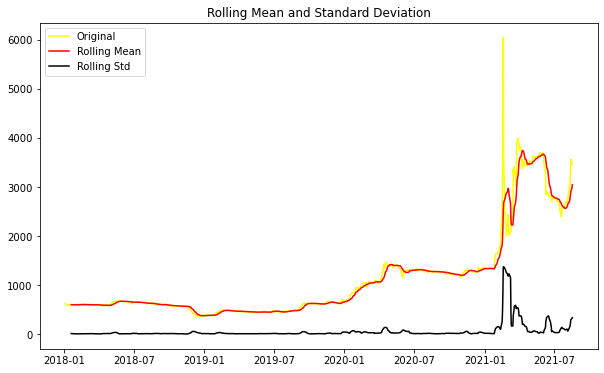

Results of dickey fuller test
Test Statistics                  0.112076
p-value                          0.966876
No. of lags used                18.000000
Number of observations used    876.000000
critical value (1%)             -3.437837
critical value (5%)             -2.864845
critical value (10%)            -2.568530
dtype: float64


In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['close'])

<Figure size 720x432 with 0 Axes>

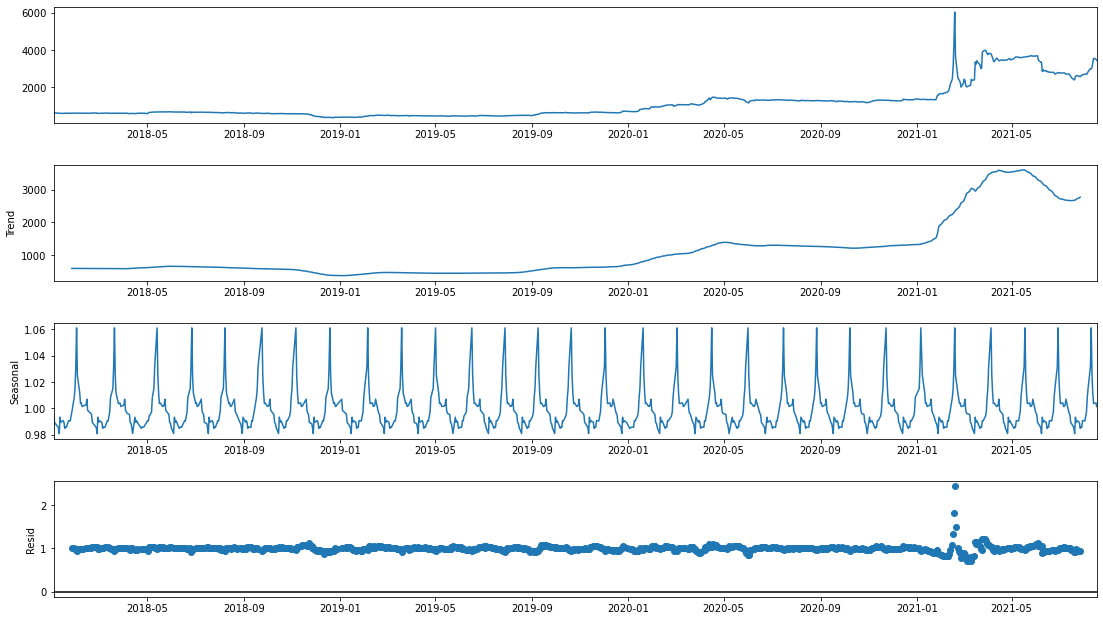

In [6]:
result = seasonal_decompose(df, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


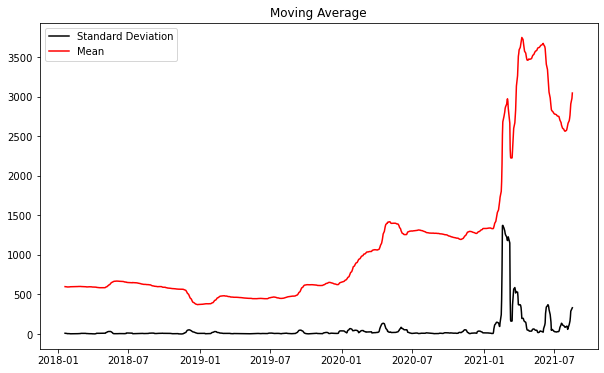

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log =(df['close'])
#df_log = np.log(df['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

In [10]:
df_log

Date
2018-01-03     614.659546
2018-01-04     612.771118
2018-01-05     612.771118
2018-01-09     599.552673
2018-01-10     597.664307
                 ...     
2021-08-11    3064.000000
2021-08-12    3317.000000
2021-08-13    3558.000000
2021-08-16    3500.000000
2021-08-17    3450.000000
Name: close, Length: 895, dtype: float64

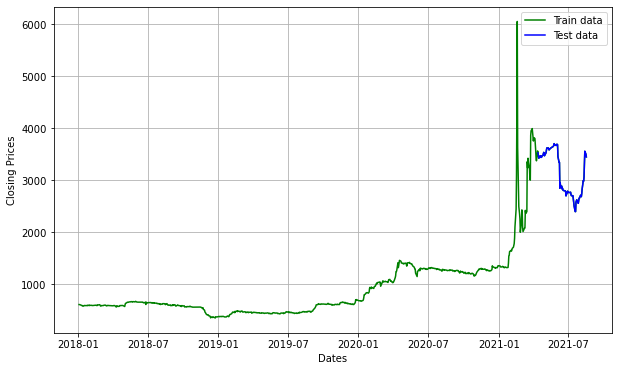

In [11]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=30, max_q=30, # maximum p and q
    m=4,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    max_P=30,
    start_Q=0,
    max_Q=30,
    D=None, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10140.920, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10127.192, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10117.622, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10139.518, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10109.227, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10057.331, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10089.566, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10055.985, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10087.973, Time=0.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10055.246, Time=0.74 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=10079.529, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=10057.228, Time=0.90 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=10059.983, Time=1.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10056.517, Time=0.93 sec
 ARIMA(5,1,0)(0,0,0

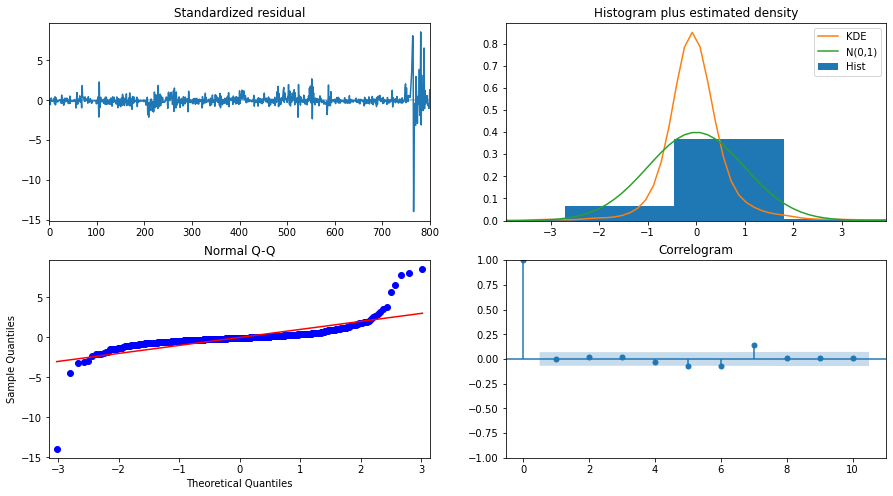

In [13]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [13]:
model = ARIMA(train_data, order=(4, 1, 1))
fitted = model.fit(disp=-1)
print(fitted.summary())

C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  801
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -5020.626
Method:                       css-mle   S.D. of innovations            127.580
Date:                Mon, 30 Aug 2021   AIC                          10055.253
Time:                        12:13:41   BIC                          10088.054
Sample:                             1   HQIC                         10067.853
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.7654      1.995      1.888      0.059      -0.144       7.675
ar.L1.D.close     0.9579      0.054     17.652      0.000       0.852       1.064
ar.L2.D.close    -0.3590      0.049     

In [14]:
fc, se, conf = fitted.forecast(90, alpha=0.05)  # 95% confidence

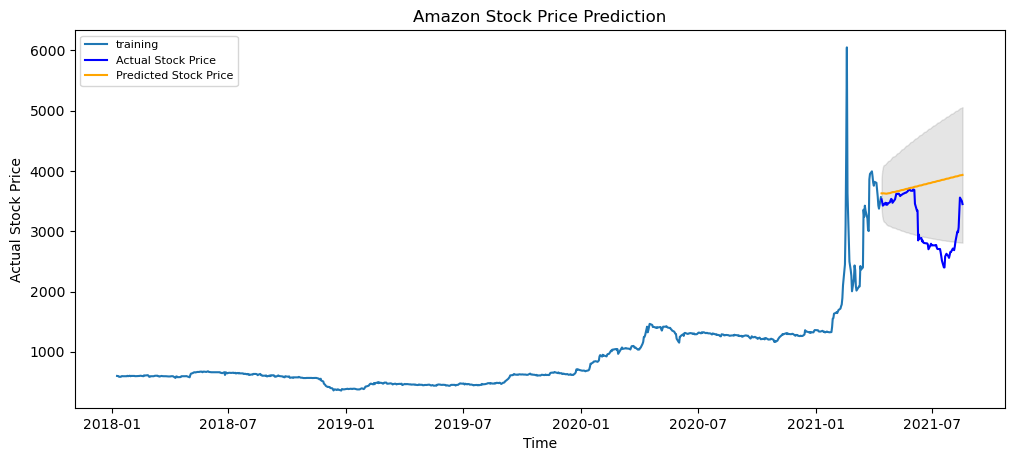

In [15]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [16]:
from dateutil.relativedelta import relativedelta
date_list = [datetime.datetime.strptime("2021-08-18", "%Y-%m-%d") + 
             relativedelta(days=x) for x in range(0,210)]


In [17]:
future = pd.DataFrame(index=date_list, columns= df.columns)
df2 = pd.concat([df, future])

In [18]:
df.shape

(895, 1)

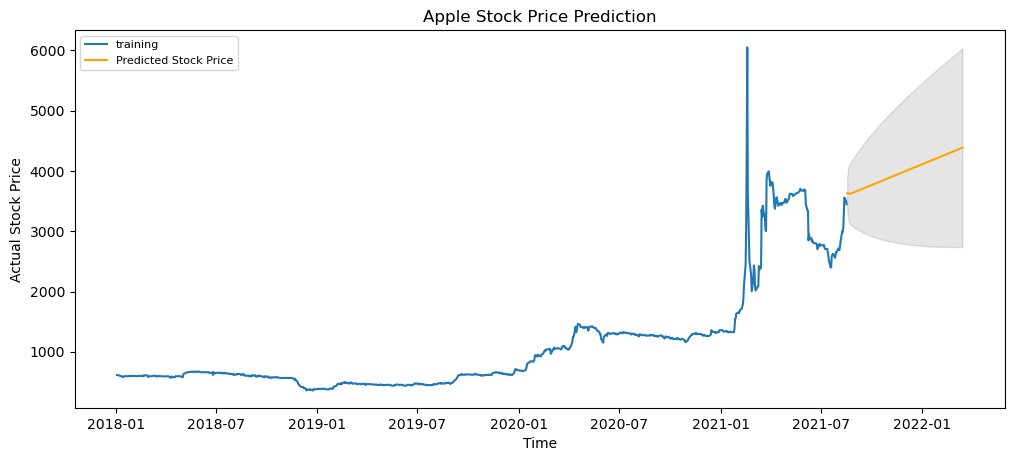

In [19]:
fc, se, conf = fitted.forecast(210, alpha=0.05)  # 95% confidence

fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='training')
#plt.plot(future, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
model_autoARIMA = auto_arima(df, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=10, max_q=10, # maximum p and q
                 # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    max_P=10,
    start_Q=0,
    max_Q=10,
    D=2, trend='ct',
    enforce_stationarity=True,
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11257.776, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11242.593, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11233.187, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11257.776, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11224.662, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11181.209, Time=0.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11205.940, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11179.528, Time=0.96 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11204.647, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11179.406, Time=1.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=11197.395, Time=0.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11182.134, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=11182.897, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11181.680, Time=1.05 sec
 ARIMA(5,1,0)(0,0,0

In [21]:
model = ARIMA(df, order=(4, 1, 1))
fitted = model.fit(disp=1)
print(fitted.summary())

C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ArtMed\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  894
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -5582.673
Method:                       css-mle   S.D. of innovations            124.647
Date:                Mon, 30 Aug 2021   AIC                          11179.346
Time:                        12:14:18   BIC                          11212.916
Sample:                             1   HQIC                         11192.174
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.9442      2.153      1.368      0.171      -1.275       7.163
ar.L1.D.close     0.9556      0.067     14.190      0.000       0.824       1.088
ar.L2.D.close    -0.3391      0.046     

In [22]:
fc, se, conf = fitted.forecast(210, alpha=0.05)  # 95% confidence

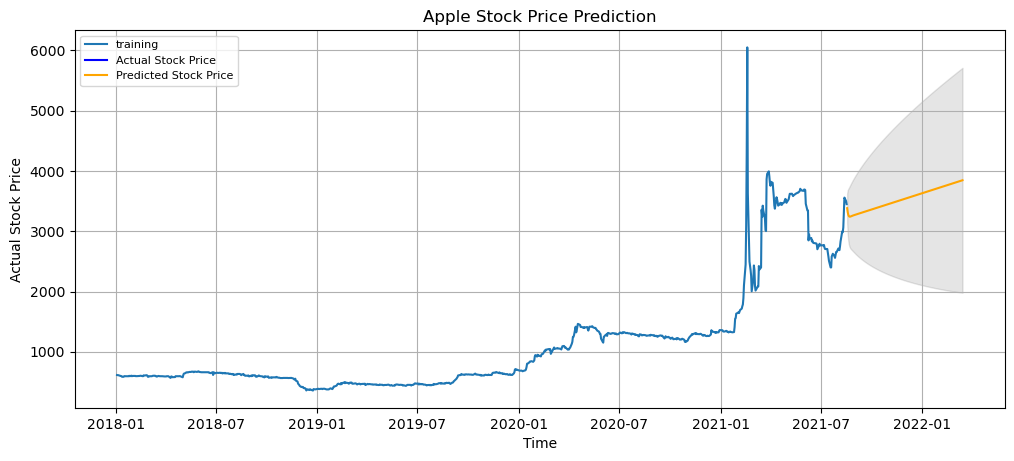

In [23]:
fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.grid(True)
plt.plot(df, label='training')
plt.plot(future, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
print('from {} to {}, predicted {}'.format(lower_series[-1], upper_series[-1], fc_series[-1]))

from 1980.1711644761176 to 5710.917141070053, predicted 3845.5441527730854


In [24]:
fc_series['2021-08-30']

3265.502333118316

In [31]:
lower_series['2021-08-30']

2507.646274046222

In [25]:
upper_series['2021-08-30']

3876.907342395458